# CIS 545 Homework 2: Graphs

In [1]:
# Execute this once, the first time you run
#!pip install networkx

# Disable Python warning messages - you should probably only run this before submission

import warnings
warnings.filterwarnings('ignore')

## Step 2.1 Spark Setup

In [2]:
# TODO: Connect to Spark as per Step 2.1
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()

In [3]:
# Load some dummy data, which should be overwritten in Step 2.2

answers_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456},\
                                    {'from_node': 456, 'to_node': 789},
                                    {'from_node': 456, 'to_node': 890}])
comments_answers_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])
comments_questions_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])

graph_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])

## Step 2.2 Loading

In [4]:
# TODO: load data as per Step 2.2

# Read lines from the text file
s, txt = 'sx-stackoverflow-', '.txt'
a2q, c2a, c2q = s + 'a2q' + txt, s + 'c2a' + txt, s + 'c2q' + txt

answers_sdf = spark.read.load(a2q, format="text")
comments_answers_sdf = spark.read.load(c2a, format="text")
comments_questions_sdf  = spark.read.load(c2q, format="text")

## Step 2.2 Results

In [5]:
answers_sdf.count()

17823525

In [6]:
answers_sdf.show()

+----------------+
|           value|
+----------------+
|  9 8 1217567877|
|  1 1 1217573801|
| 13 1 1217606247|
| 17 1 1217617639|
| 48 2 1217618182|
| 17 1 1217618239|
| 19 9 1217618357|
|13 23 1217618560|
|13 11 1217618799|
|23 23 1217619360|
|35 33 1217620542|
|39 33 1217620597|
|43 22 1217620971|
|17 32 1217621272|
|39 40 1217621416|
|37 40 1217621670|
|45 45 1217621917|
|17 17 1217622124|
|49 13 1217623079|
|13 23 1217623216|
+----------------+
only showing top 20 rows



In [7]:
answers_sdf.printSchema()

root
 |-- value: string (nullable = true)



In [8]:
comments_answers_sdf.count()

25405374

In [9]:
comments_answers_sdf.show(10)

+--------------------+
|               value|
+--------------------+
|     1 91 1220713630|
|     3 91 1220713792|
|  380 350 1220715736|
|4642 2257 1220734307|
|4642 1324220 1220...|
|2495 4285 1220736640|
|4642 4893 1220737355|
|2515 4903 1220738560|
|2515 4893 1220739071|
|  199 199 1220741079|
+--------------------+
only showing top 10 rows



In [10]:
comments_answers_sdf.printSchema()

root
 |-- value: string (nullable = true)



In [11]:
comments_questions_sdf.count()

20268151

In [12]:
comments_questions_sdf.show(10)

+--------------------+
|               value|
+--------------------+
|4550 4550 1220729190|
|  242 184 1220733503|
|4213 4946 1220768149|
|    91 91 1220768295|
|2658 1874 1220771891|
|4035 1874 1220773037|
|2257 4489 1220802041|
|  577 577 1220834891|
|4489 4489 1220853536|
| 828 2783 1220854143|
+--------------------+
only showing top 10 rows



In [13]:
comments_questions_sdf.printSchema()

root
 |-- value: string (nullable = true)



## Step 2.3

In [14]:
# TODO: wrangling work in Step 2.3.  Add as many Cells as you need

# Create temporary views to enable SQL queries
answers_sdf.createOrReplaceTempView("answers_sdf")
comments_answers_sdf.createOrReplaceTempView("comments_answers_sdf")
comments_questions_sdf.createOrReplaceTempView("comments_questions_sdf")

# Split and cast columns
answers_sdf = answers_sdf.select(
    F.split(answers_sdf.value, ' ')[0].alias('from_node').cast('integer'),
    F.split(answers_sdf.value, ' ')[1].alias('to_node').cast('integer'),
    F.split(answers_sdf.value, ' ')[2].alias('timestamp').cast('integer'))
comments_answers_sdf = comments_answers_sdf.select(
    F.split(comments_answers_sdf.value, ' ')[0].alias('from_node').cast('integer'),
    F.split(comments_answers_sdf.value, ' ')[1].alias('to_node').cast('integer'),
    F.split(comments_answers_sdf.value, ' ')[2].alias('timestamp').cast('integer'))
comments_questions_sdf = comments_questions_sdf.select(
    F.split(comments_questions_sdf.value, ' ')[0].alias('from_node').cast('integer'),
    F.split(comments_questions_sdf.value, ' ')[1].alias('to_node').cast('integer'),
    F.split(comments_questions_sdf.value, ' ')[2].alias('timestamp').cast('integer'))

# Add columns with literal values
answers_sdf            = answers_sdf.withColumn('edge_type', F.lit('answer'))
comments_questions_sdf = comments_questions_sdf.withColumn('edge_type', F.lit('comment-on-question'))
comments_answers_sdf   = comments_answers_sdf.withColumn('edge_type', F.lit('comment-on-answer'))

# Create a single Spark DataFrame 'graph_sdf' with unionAll
graph_sdf = answers_sdf.unionAll(comments_questions_sdf).unionAll(comments_answers_sdf)

## Step 2.3 Results

In [15]:
answers_sdf.count()

17823525

In [16]:
answers_sdf.show(5)

+---------+-------+----------+---------+
|from_node|to_node| timestamp|edge_type|
+---------+-------+----------+---------+
|        9|      8|1217567877|   answer|
|        1|      1|1217573801|   answer|
|       13|      1|1217606247|   answer|
|       17|      1|1217617639|   answer|
|       48|      2|1217618182|   answer|
+---------+-------+----------+---------+
only showing top 5 rows



In [17]:
answers_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [18]:
comments_answers_sdf.count()

25405374

In [19]:
comments_answers_sdf.show(5)

+---------+-------+----------+-----------------+
|from_node|to_node| timestamp|        edge_type|
+---------+-------+----------+-----------------+
|        1|     91|1220713630|comment-on-answer|
|        3|     91|1220713792|comment-on-answer|
|      380|    350|1220715736|comment-on-answer|
|     4642|   2257|1220734307|comment-on-answer|
|     4642|1324220|1220735746|comment-on-answer|
+---------+-------+----------+-----------------+
only showing top 5 rows



In [20]:
comments_answers_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [21]:
 comments_questions_sdf.count()

20268151

In [22]:
comments_questions_sdf.show(5)

+---------+-------+----------+-------------------+
|from_node|to_node| timestamp|          edge_type|
+---------+-------+----------+-------------------+
|     4550|   4550|1220729190|comment-on-question|
|      242|    184|1220733503|comment-on-question|
|     4213|   4946|1220768149|comment-on-question|
|       91|     91|1220768295|comment-on-question|
|     2658|   1874|1220771891|comment-on-question|
+---------+-------+----------+-------------------+
only showing top 5 rows



In [23]:
comments_questions_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [24]:
graph_sdf.count()

63497050

In [25]:
graph_sdf.show(5)

+---------+-------+----------+---------+
|from_node|to_node| timestamp|edge_type|
+---------+-------+----------+---------+
|        9|      8|1217567877|   answer|
|        1|      1|1217573801|   answer|
|       13|      1|1217606247|   answer|
|       17|      1|1217617639|   answer|
|       48|      2|1217618182|   answer|
+---------+-------+----------+---------+
only showing top 5 rows



In [26]:
graph_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- edge_type: string (nullable = false)



## Step 2.4

In [27]:
# You may put any computations you need here

from pyspark.sql.functions import *

# (1) Top 10 users by number of questions
top_users_q = graph_sdf.groupBy('to_node').count().orderBy('count', ascending = False)

# Follow the schema  (user, ansCounts)
top_users_q = top_users_q.withColumnRenamed('to_node', 'user')
top_users_q = top_users_q.withColumnRenamed('count', 'ansCounts')

# (2) Top 10 users by number of answers to questions by distinct users
ix_ans = graph_sdf.edge_type == 'answer'
top_users_a = graph_sdf.filter(ix_ans).groupBy('from_node').agg(countDistinct('to_node'))

# Follow the schema  (user, ansCounts)
top_users_a = top_users_a.withColumnRenamed('from_node', 'user')
top_users_a = top_users_a.withColumnRenamed('count(DISTINCT to_node)', 'ansCounts')
top_users_a = top_users_a.sort('ansCounts',ascending = False)

# (3) Ignored Users
has_comments = comments_answers_sdf.distinct().select("to_node")
has_answers  = answers_sdf.distinct().select("to_node")
ignored_q = has_comments.subtract(has_answers).distinct()
ignored_count = ignored_q.count()

# (4) Most helpful pairs
# Remove self-answered rows (1,119,931)
answers_f_sdf = answers_sdf.filter(answers_sdf.to_node != answers_sdf.from_node)

# Order by (A, B or B , A)
pairs_sdf = answers_f_sdf.groupBy(["to_node", "from_node"]).count().orderBy('count', ascending = False)

# Follow the schema  (user1, user2, ansCounts)
pairs_sdf = pairs_sdf.withColumnRenamed('to_node', 'user1')
pairs_sdf = pairs_sdf.withColumnRenamed('from_node', 'user2')
pairs_sdf = pairs_sdf.withColumnRenamed('count', 'ansCounts')

## Step 2.4.1 Results

In [28]:
# TODO: output dataframe with top 10 users by number of questions
top_users_q.show(10)

+-------+---------+
|   user|ansCounts|
+-------+---------+
|  22656|    93143|
| 548225|    54410|
|  29407|    45824|
| 157882|    39576|
|1144035|    38909|
| 100297|    37752|
| 505088|    36626|
| 115145|    35411|
|   6309|    32059|
|  23354|    28557|
+-------+---------+
only showing top 10 rows



In [29]:
# TODO: output top 10 users by number of answers to questions by distinct users
top_users_a.show(10)

+-------+---------+
|   user|ansCounts|
+-------+---------+
|  22656|    22860|
|1144035|    21032|
| 548225|    14127|
|  29407|    13043|
| 115145|    12243|
|  19068|    12114|
| 100297|    11486|
|  34397|    11368|
|  17034|    11347|
|   6309|    11057|
+-------+---------+
only showing top 10 rows



## Step 2.4.2 Results

In [30]:
# TODO: number of users whose questions have been commented on but never been answered.
ignored_count

288765

## Step 2.4.3 Results

In [31]:
# TODO: top 10 pairs of users by mutual answers, along with the number of questions they have mutually answered
pairs_sdf.show(10)

+------+-------+---------+
| user2|  user1|ansCounts|
+------+-------+---------+
|315935| 742402|      155|
|217408|2258442|      105|
|  6309| 399145|       81|
|157882|1391249|       78|
|157882| 240337|       76|
|  6309| 470184|       76|
| 91299| 167454|       73|
|505088|  46207|       72|
|505088| 988445|       69|
| 15168| 366797|       63|
+------+-------+---------+
only showing top 10 rows



# Step 3

In [32]:
# TODO: Fill in according to HW spec
highest_indegree_sdf = graph_sdf.groupBy('to_node').count().orderBy('count',ascending = False)
highest_indegree_sdf = highest_indegree_sdf.withColumnRenamed('to_node', 'node')
highest_indegree_sdf = highest_indegree_sdf.withColumnRenamed('count', 'indegree')

highest_outdegree_sdf = graph_sdf.groupBy('from_node').count().orderBy('count',ascending = False)
highest_outdegree_sdf = highest_outdegree_sdf.withColumnRenamed('from_node', 'node')
highest_outdegree_sdf = highest_outdegree_sdf.withColumnRenamed('count', 'outdegree')

## Step 3 Results

In [33]:
highest_indegree_sdf.show(5)

+-------+--------+
|   node|indegree|
+-------+--------+
|  22656|   93143|
| 548225|   54410|
|  29407|   45824|
| 157882|   39576|
|1144035|   38909|
+-------+--------+
only showing top 5 rows



In [34]:
highest_outdegree_sdf.show(5)

+-------+---------+
|   node|outdegree|
+-------+---------+
|  22656|   101663|
| 505088|    65522|
|  17034|    65260|
|1491895|    62746|
| 100297|    54330|
+-------+---------+
only showing top 5 rows



## Step 4

In [49]:
#
# Step 4.1 Pre-processing
#


def spark_bfs(G, origins, max_depth):
    schema = StructType([
        StructField('node', IntegerType(), True)
    ])
    
    frontier_sdf = spark.createDataFrame(origins, schema).cache()
    return_sdf = frontier_sdf.select(col('node')).withColumn('depth', lit('0'))

    # Divide into shards for performance purposes
    G.cache().repartition(100,'from_node')

    # Initialize to enable SQL
    G.createOrReplaceTempView('G')
    frontier_sdf.createOrReplaceTempView('frontier_sdf')
    return_sdf.createOrReplaceTempView('return_sdf')
    visited_sdf = frontier_sdf.cache()

    i = 0
    while i < max_depth:
        if i > 0:
            visited_sdf = visited_sdf.unionAll(frontier_sdf).cache()

        visited_sdf.createOrReplaceTempView('visited_sdf')
        G.createOrReplaceTempView('G')
        frontier_sdf.createOrReplaceTempView('frontier_sdf')

        # Find new frontier nodes
        frontier_sdf = frontier_sdf.join(G,frontier_sdf.node == G.from_node, 'inner')
        to_join = frontier_sdf.select('to_node')
        frontier_sdf = to_join.join(visited_sdf, to_join.to_node == visited_sdf.node, 'leftanti').cache()

        # update return_sdf
        to_append = frontier_sdf.select('to_node')
        to_append = to_append.withColumn('depth', lit(i + 1))
        return_sdf = return_sdf.unionAll(to_append)
        return_sdf.createOrReplaceTempView('return_sdf')
        # Fix frontier column name
        frontier_sdf = frontier_sdf.select(col('to_node').alias('node'))
        i = i + 1
        
    return return_sdf

## Step 4.1

In [50]:
# TODO: comment out this line once your code is ready
bfs_sdf = spark.createDataFrame([{'node': 123, 'depth': 1}, {'node': 456, 'depth': 2}])

# TODO: enable this once your code is ready
origin_map = [{'node': 4550}, {'node': 242}]
bfs_sdf = spark_bfs(comments_questions_sdf, origin_map, 2)
bfs_sdf.count()

397

## Step 4.1 Results

In [43]:
bfs_sdf.show(10)

+-------+-----+
|   node|depth|
+-------+-----+
|   4550|    0|
|    242|    0|
|1619254|    1|
|2332659|    1|
|5504881|    1|
|1139389|    1|
|1940564|    1|
| 818089|    1|
|3047450|    1|
|4773326|    1|
+-------+-----+
only showing top 10 rows



## Step 4.2

In [115]:
#
# Step 4.2 Pre-processing
#

bfs_sdf.createOrReplaceTempView('bfs_sdf')
filtered_bfs_sdf = bfs_sdf.filter("depth == 2").groupBy(bfs_sdf.node)
filtered_bfs_sdf = filtered_bfs_sdf.count().filter("count > 1").select("node")

def filter_sdf(sdf):
    a, b = sdf, sdf
    a.createOrReplaceTempView('a')
    b.createOrReplaceTempView('b')
    query = 'SELECT a.from_node AS from_node, b.to_node AS to_node FROM a, b WHERE a.from_node != b.to_node' 
    return spark.sql(query)


def friend_rec(filtered_bfs_sdf, graph_sdf):
    filtered_bfs_sdf.createOrReplaceTempView('filtered_bfs_sdf')
    graph_sdf.createOrReplaceTempView('graph_sdf')
    
    # Divide into shards for performance purposes
    graph_sdf.cache().repartition(100,'from_node')

    q1a = 'SELECT DISTINCT b.from_node, b.to_node FROM filtered_bfs_sdf a '
    q1b = 'JOIN graph_sdf b ON a.node = b.from_node'
    q2a = 'SELECT a.from_node, a.to_node FROM d_sdf a ' 
    q2b = 'WHERE a.to_node IN (SELECT b.node FROM filtered_bfs_sdf b)'
    q1, q2 = q1a + q1b, q2a + q2b
    d_sdf = spark.sql(q1).cache()

    filtered_bfs_sdf.createOrReplaceTempView('filtered_bfs_sdf')
    d_sdf.createOrReplaceTempView('d_sdf')
    return filter_sdf(spark.sql(q2).cache())

In [116]:
# TODO: comment this line out when your function works
#friend_recommendations_sdf = spark.createDataFrame([\
                                                    #{'from_node': 123, 'to_node': 456}, \
                                                    #{'from_node': 456, 'to_node': 123}])


# TODO: enable this when your function works
friend_recommendations_sdf = friend_rec(filtered_bfs_sdf, comments_questions_sdf)
friend_recommendations_sdf.count()

1721

## Step 4.2 Results

In [109]:
friend_recommendations_sdf.show()

+---------+-------+
|from_node|to_node|
+---------+-------+
|    63775|3565829|
|    63775|  24872|
|    63775|4899760|
|    63775|2269511|
|    63775| 503032|
|    63775|1406214|
|    63775|1038179|
|    63775| 139605|
|    63775|  46646|
|    63775|  65120|
|    63775|5947929|
|    63775|  60602|
|    63775| 102427|
|    63775| 453447|
|    63775|  21918|
|    63775|  59017|
|    63775|1218595|
|    63775|1187554|
|    63775|1061543|
|    63775|  76028|
+---------+-------+
only showing top 20 rows



## Step 4.3: Graph visualization

### Once you have excecuted the cells in Step 4.2 and you have friend_recommendations_sdf, lets create friend_recommendations_df using toPandas(). This creates an in-memory dataFrame that we can use to build the graph. Here we have used ('from_node','to_node') as column names in friend_recommendations_sdf, please change it to what you have used in yours.

In [110]:
import networkx as nx

# TODO: create friend_graph NetworkX graph from friend_recommendations_df from friend_recommendations_sdf
friends_df = friend_recommendations_sdf.toPandas()
friend_graph = nx.from_pandas_dataframe(friends_df,'from_node','to_node')

## Step 4.3 Results

In [111]:
print ("Number of nodes (characters) in this graph is", friend_graph.order()) # number of nodes
print ("Number of edges in this graph is", len(friend_graph.edges())) # number of edges
print ("Graph diameter is", nx.diameter(friend_graph)) # maximum eccentricity

Number of nodes (characters) in this graph is 41
Number of edges in this graph is 820
Graph diameter is 1


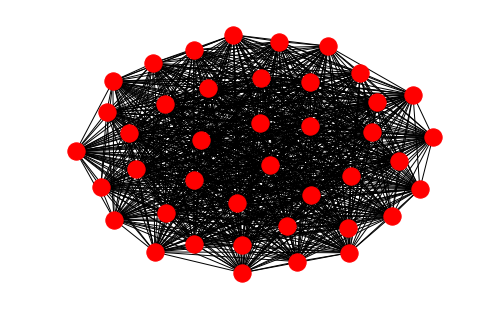

In [112]:
 %matplotlib inline
 nx.draw(friend_graph)